In [1]:
import sys
sys.path.append("../code")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)

from sklearn.datasets import make_moons

dataset = 2
import mnist_reader 
    
X_train, y_train = mnist_reader.load_mnist('../data/mnist', kind='train')
X_test, y_test = mnist_reader.load_mnist('../data/mnist', kind='t10k')

#n = 2000
#np.random.seed(6333)
#ids = np.random.choice(range(60000),n, replace=False)
#X_train, y_train = X_train[ids], y_train[ids]

X_train = X_train.astype(np.float32)
max_val = np.max(X_train)
X_train = X_train/max_val

X_test = X_test/max_val

n = X_train.shape[0]

classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

print(X_train.shape, y_train.shape, X_train.dtype)

#Torch Setups
from sklearn.decomposition import PCA

#import torch
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#X_torch = torch.as_tensor(X_train, dtype=torch.float32, device=device)

n_components = 2

pca = PCA(n_components = n_components)
x_init = pca.fit_transform(X_train)
x_init = x_init - np.mean(x_init, axis=0)

def print_stats(X):
    print('size: ', X.shape)
    print('Mean:', np.mean(X))
    print('Max: ', np.max(X))
    print('Min: ', np.min(X))
    print('STD: ', np.std(X))
    
    return

print('Training Statistics')
print_stats(X_train)
#print('Test Statistics')
#print_stats(X_test)


epochs = 200
n_neighbors= 15
n_components = 2
MIN_DIST = 0.1

    
%matplotlib inline

%load_ext autoreload
%autoreload 2

(60000, 784) (60000,) float32
Training Statistics
size:  (60000, 784)
Mean: 0.13066062
Max:  1.0
Min:  0.0
STD:  0.30810776


In [2]:
#from umap import UMAP

#ump = UMAP(n_components=2,
#           min_dist=0.1,
#          init='spectral',
#          random_state=42)

#y_umap = ump.fit_transform(X_train)

#print(ump._a, ump._b)

In [3]:
import numpy as np

import numba
from numba import prange

import random

import scipy.sparse

import gc


@numba.jit(nopython=True, parallel=True)
def euclidean_distances_numba(X, squared = True):
    n = X.shape[0]
    xcorr = np.zeros((n,n),dtype=X.dtype)
    for i in prange(n):
        for j in range(i,n):
            dist = np.sum( np.square(X[i,:] - X[j,:]) )
            if not squared:
                dist = np.sqrt(dist)
            xcorr[i,j] = dist
            xcorr[j,i] = dist
    
    return xcorr

#@numba.jit(nopython=True)
def get_weight_function(dists, rho, sigma):
    d = dists - rho
    #print(d)
    d[d<0] = 0
    weight = np.exp(- d / sigma )
    return weight

#@numba.jit(nopython=True)
def search_sigma(dists, rho, k, tol = 10**-5, n_iteration=200):
    sigma_min = 0
    sigma_max = 1000
    
    cur_sigma = 100
    
    logk = np.log2(k)
    #print(logk)
    
    for i in range(n_iteration):
        
        cur_sigma = (sigma_min+sigma_max)/2
        probs = get_weight_function(dists,rho,cur_sigma)
        weight = np.sum(probs)
        #print(weight)
        
        if np.abs(logk - weight) < tol:
            break
        
        if weight < logk:
            sigma_min = cur_sigma
        else:
            sigma_max = cur_sigma
        
    return cur_sigma, probs

@numba.jit(nopython=True, parallel=True)
def symmetrization_step(prob):
    n = prob.shape[0]
    P = np.zeros((n,n),dtype=np.float32)

    for i in prange(n):
        #if i%1000 == 0:
        #    print('Completed ', i, ' of ', n)
        for j in prange(i,n):
            p = prob[i,j] + prob[j,i] - prob[i,j] * prob[j,i] #t-conorm
            P[i,j] = p
            P[j,i] = p
            
    return P

def get_prob_matrix(X, n_neighbors=15):
    n = X.shape[0]
    dist = euclidean_distances_numba(X, squared = False)
    sort_idx = np.argsort(dist,axis=1)
    #sort_idx = sort_idx.astype(np.int32)
    sort_idx = sort_idx[:,1:n_neighbors+1]
    
    rho = [ dist[i, sort_idx[i,0] ] for i in range(n)]
    rho = np.array(rho)
    
    

    sigmas = []

    directed_graph = []


    #'''
    for i in range(n):
        if (i+1)%1000 == 0:
            print('Processed ', i+1, ' of ', n, ' samples.')
        sigma, weights = search_sigma(dists = dist[i,sort_idx[i,:]],rho = rho[i],k = n_neighbors)

        probs = np.zeros(n)
        probs[sort_idx[i,:]] = weights
        #print(sum(weights), np.log2(n_neighbors))
        #print(sort_idx[i,:])
        #print(probs[1770:1780])

        directed_graph.append(probs)

    directed_graph = np.array(directed_graph).astype(np.float32)
    prob = directed_graph
    
    P = symmetrization_step(prob)
    #P = prob
    
    graph = scipy.sparse.coo_matrix(P)
    
    return graph

def make_epochs_per_sample(weights, n_epochs):
    """Given a set of weights and number of epochs generate the number of
    epochs per sample for each weight.
    Parameters
    ----------
    weights: array of shape (n_1_simplices)
        The weights ofhow much we wish to sample each 1-simplex.
    n_epochs: int
        The total number of epochs we want to train for.
    Returns
    -------
    An array of number of epochs per sample, one for each 1-simplex.
    Copied from UMAP repo: https://github.com/lmcinnes/umap/
    """
    result = -1.0 * np.ones(weights.shape[0], dtype=np.float64)
    n_samples = n_epochs * (weights / weights.max())
    result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]
    return result
    

In [4]:
#graph = get_prob_matrix(X_train,n_neighbors=n_neighbors)
#print(len(graph.data))
#print('prune value: ', graph.data.max() / float(epochs))
#graph.data[graph.data < (graph.data.max() / float(epochs))] = 0.0
#graph.eliminate_zeros()
#print(len(graph.data))
#epochs_per_sample_og = make_epochs_per_sample(graph.data, epochs)
#gc.collect()

with open('MNIST_epoch_per_sample_og.npy', 'rb') as f:
    epochs_per_sample_og = np.load(f)

from scipy import sparse
graph = sparse.load_npz('MNIST_graph.npz')

In [5]:
print(epochs_per_sample_og.data.shape)

#with open('MNIST_epoch_per_sample_og.npy', 'wb') as f:
#    np.save(f,epochs_per_sample_og)

#from scipy import sparse
#sparse.save_npz("MNIST_graph.npz", graph)

(1324544,)


(60000, 2)


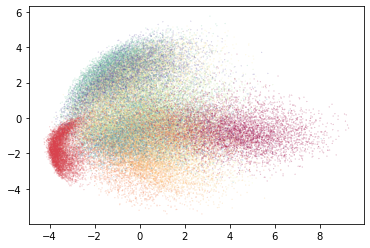

In [6]:
from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components = n_components)
init = pca.fit_transform(X_train)
emb = init.astype(np.float32).copy()

neg_sample_rate = 5
repulsion_strength=1.0

print(emb.shape)

plt.figure()
plt.scatter(emb[:,0], emb[:,1], c=y_train, s=0.01, cmap='Spectral')

Hyperparameters a = 1.576943460405378 and b = 0.8950608781227859


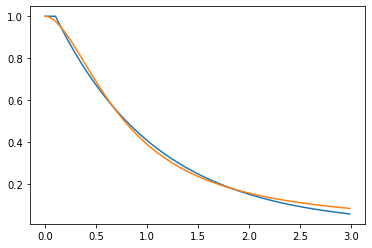

In [7]:


x = np.linspace(0, 3, 300)

y = (x>MIN_DIST) * np.exp(-x+MIN_DIST)
y[x<=MIN_DIST] = 1.0

function = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(function, x, y) 

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

x_p = np.arange(0,3,0.01)
y_p = np.exp(- (x_p-MIN_DIST) * ( (x_p - MIN_DIST) >=0 ) )
y_p2 = 1 / (1 + a*x_p**(2*b))

plt.figure()
plt.plot(x_p,y_p, label='Target')
plt.plot(x_p,y_p2, label='Fitted')



In [8]:
attr_coeff = []
rep_coeff = []

idx_to_map = 100


@numba.jit(nopython=True)
def clip(x,val=4.0):

    if x>val:
        return val
    elif x<-val:
        return -val
    else:
        return x
    
@numba.jit(nopython=True)
def update_attraction(x, y, a, b, dim, lr, P, idx):
    dist = np.sum((x - y)**2)

    if dist>0.0:
        grad_coeff = 2*a*b*dist**(b-1.0) / (1 + a * dist**b) 
    else:
        grad_coeff = 0.0
    

    for d in range(dim):
        mv = clip(grad_coeff * P * (x[0,d]-y[0,d]))  # * P[idx,idy]
        mv = mv * lr

        x[0,d] -= mv
        y[0,d] += mv
        
    return

@numba.jit(nopython=True)
def update_repulsion(x, y, a, b, dim, lr, P, idx, eps):
    dist = np.sum((x - y)**2)

    if dist>0.0:
        grad_coeff = 2 * repulsion_strength * b / ( (0.001+dist) * (1.0 + a * dist**b) ) + eps
    else:
        grad_coeff = 0
        
    
    for d in range(dim):
        
        grad = clip(grad_coeff  * (x[0,d]-y[0,d]) * (1-P))
        mv = grad * lr

        x[0,d] += mv
        

    return


@numba.jit(nopython=True)
def one_step_in_a_set(emb, idx, rows, columns, a, b, dim,
                   n_points,
                   epochs_per_sample,
                   epoch_of_next_sample,
                   epochs_per_negative_sample,
                   epoch_of_next_negative_sample,
                   lr, epoch,
                   eps=0):
    
    if epoch_of_next_sample[idx] <= epoch:
        x_idx = rows[idx]
        y_idx = columns[idx]
        
        
        x = emb[x_idx:x_idx+1,:]
        y = emb[y_idx:y_idx+1, :]
            
        update_attraction(x, y, a, b, dim, lr, 1, idx)
        
        epoch_of_next_sample[idx] += epochs_per_sample[idx]
        
        n_neg_samples = int(
                (epoch - epoch_of_next_negative_sample[idx]) / epochs_per_negative_sample[idx]
            )
        
        for i in range(n_neg_samples):
            y_idx = np.random.choice(n_points)
            
            if x_idx == y_idx:
                continue
            
            y = emb[y_idx:y_idx+1, :]
                
            update_repulsion(x, y, a, b, dim, lr, 0, idx, eps)
            
        epoch_of_next_negative_sample[idx] += (
                n_neg_samples * epochs_per_negative_sample[idx]
            )
            
    return 

@numba.jit(nopython=True,parallel=True)
def one_epoch_2sets_2(emb,
                     rows, columns,
                     n_points,
                     n_edges,
                     a, b, dim,
                     lr, epoch,
                     epochs_per_sample,
                     epoch_of_next_sample,
                     epochs_per_negative_sample,
                     epoch_of_next_negative_sample,
                     eps=0,
                     repulsion_strength=1.0):
    '''
    Set1 = 1 * np.ones(epochs_per_sample_1.shape[0])
    Set2 = 2 * np.ones(epochs_per_sample_2.shape[0])
    Set = np.random.permutation(np.concatenate((Set1,Set2)))
    '''
    
    for i in prange(n_edges):

        one_step_in_a_set(emb=emb, idx=i, 
                              rows=rows, columns=columns, a=a, b=b, dim=dim,
                              n_points=n_points,
                              epochs_per_sample=epochs_per_sample,
                              epoch_of_next_sample=epoch_of_next_sample,
                              epochs_per_negative_sample=epochs_per_negative_sample,
                              epoch_of_next_negative_sample=epoch_of_next_negative_sample,
                              lr=lr, epoch=epoch,
                              eps=eps)
    
    return


def get_ab(MIN_DIST):
    x = np.linspace(0, 3, 300)

    y = (x>MIN_DIST) * np.exp(-x+MIN_DIST)
    y[x<=MIN_DIST] = 1.0
    
    function = lambda x, a, b: 1 / (1 + a*x**(2*b))

    p , _ = optimize.curve_fit(function, x, y) 
    
    return p[0], p[1]

#As = [1e-6, 1e-3, 1e-2, 1e-1, 1, 1.2, 1.5, 1.8, 2.0, 2.2, 2.5, 2.8, 3.0, 3.2, 3.5, 3.8, 4.0]

#EPSs = [1.0, 0.9, 0.8, 0.6, 0.5, 0.4, 0.3, 0.2, 
#      0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

EPSs = np.sort([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.0002,0.0003,0.0004,0.0005,0.0006])

from sklearn.decomposition import PCA

n_components = 2

neg_sample_rate = 5
repulsion_strength=1.0

no_of_epss = len(EPSs)


embeddings = []
params = []

print(a,b)

for nr in range(no_of_epss):

    a = 1.576943460405378
    b = 0.8950608781227859
    eps = EPSs[nr]
    
    params.append([a,b,eps])
    
    pca = PCA(n_components = n_components)
    init = pca.fit_transform(X_train)
    emb = init.astype(np.float32).copy()
    expansion = 10.0 / np.abs(emb).max()
    emb = (emb * expansion).astype(np.float32)


    epochs_per_sample = epochs_per_sample_og.copy()
    epoch_of_next_sample = epochs_per_sample.copy()
    epochs_per_negative_sample = epochs_per_sample / neg_sample_rate
    epoch_of_next_negative_sample = epochs_per_negative_sample.copy()

    init_lr = 1.0

    n_edges = epochs_per_sample.shape[0]

    np.random.seed(500)

    import timeit

    for epoch in range(epochs):

        if epoch%100==0:
            print(nr, ': epoch ', epoch, 'of ', epochs)
        #print('epoch ', epoch, 'of ', epochs)
        start = timeit.default_timer()

        lr = init_lr * (1.0 - float(epoch)/float(epochs))

        one_epoch_2sets_2(emb=emb, 
                         rows=graph.row, columns=graph.col, 
                         n_points=X_train.shape[0],
                         n_edges = n_edges,
                         a=a, b=b, dim=n_components,
                         lr=lr, epoch=epoch+1,
                         epochs_per_sample=epochs_per_sample,
                         epoch_of_next_sample=epoch_of_next_sample,
                         epochs_per_negative_sample=epochs_per_negative_sample,
                         epoch_of_next_negative_sample=epoch_of_next_negative_sample,
                         repulsion_strength=repulsion_strength,
                         eps=eps)

        stop = timeit.default_timer()
        #print('Time for epoch ', epoch, ': ', stop - start) 
           
    embeddings.append(emb)

    
embeddings = np.array(embeddings)

with open('embeddings/varying_limit_2.npy', 'wb') as f:
    np.save(f,embeddings)
    np.save(f,params)

1.576943460405378 0.8950608781227859
0 : epoch  0 of  200
0 : epoch  100 of  200
1 : epoch  0 of  200
1 : epoch  100 of  200
2 : epoch  0 of  200
2 : epoch  100 of  200
3 : epoch  0 of  200
3 : epoch  100 of  200
4 : epoch  0 of  200
4 : epoch  100 of  200
5 : epoch  0 of  200
5 : epoch  100 of  200
6 : epoch  0 of  200
6 : epoch  100 of  200
7 : epoch  0 of  200
7 : epoch  100 of  200
8 : epoch  0 of  200
8 : epoch  100 of  200
9 : epoch  0 of  200
9 : epoch  100 of  200
10 : epoch  0 of  200
10 : epoch  100 of  200


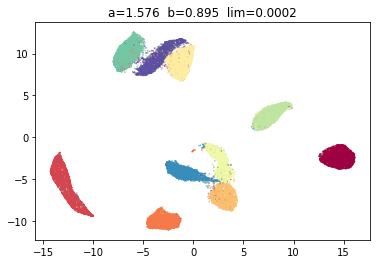

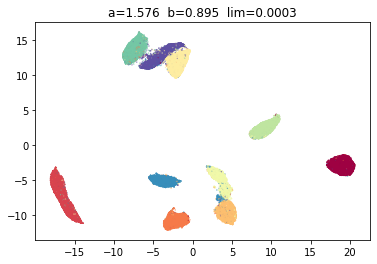

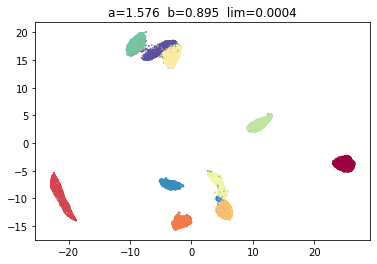

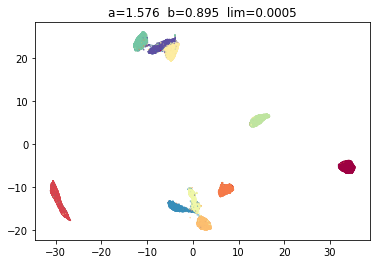

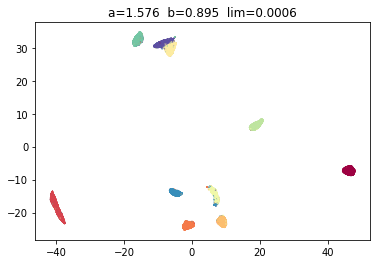

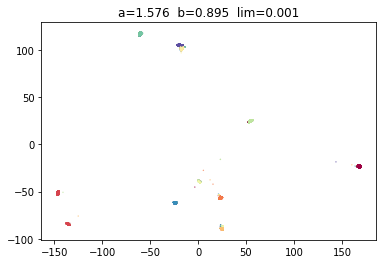

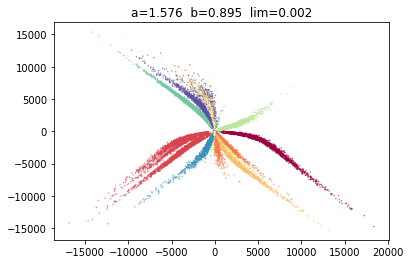

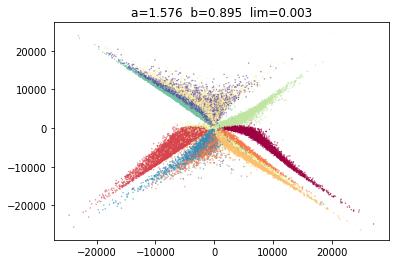

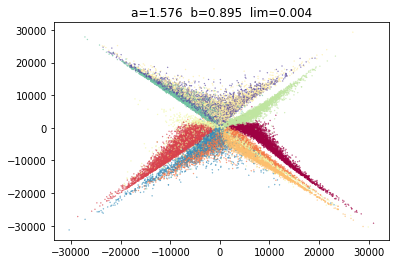

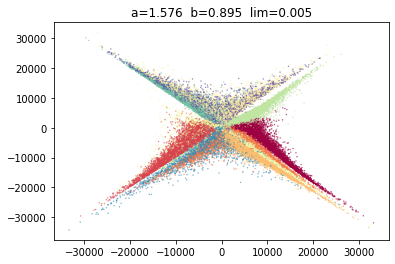

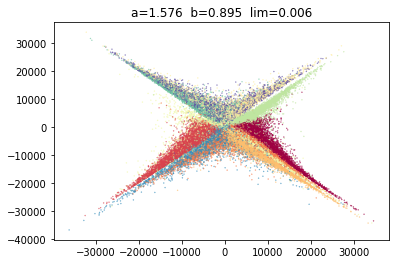

In [9]:
for i in range(no_of_epss):
    emb = embeddings[i]
    pm = params[i]
    plt.figure()
    plt.scatter(emb[:,0], emb[:,1], c=y_train, s=0.1, cmap='Spectral')
    plt.title('a='+str(pm[0])[:5]+'  b='+str(pm[1])[:5]+'  lim='+str(pm[2]))